In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

import plotly
from plotly import graph_objs 
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)

from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Embedding
import nbconvert
import seaborn as sns

from sklearn.model_selection import train_test_split

import string
import nltk
from nltk.corpus import stopwords

In [3]:
df = pd.read_csv("labeled_data.csv")
df.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [4]:
df = df.drop("Unnamed: 0", axis=1)
df = df.rename(columns = {'offensive_language': 'offensive', 'hate_speech': 'hate'})

In [6]:
df.shape

(24783, 6)

In [9]:
hate = len(df[df['class']==0])
neutral = len(df[df['class']==2])
offensive = len(df[df['class']==1])
print(f'hate : {hate} , neutral : {neutral}, offensive : {offensive}')

hate : 1430 , neutral : 4163, offensive : 19190


In [11]:
dist = [graph_objs.Bar(
    x=['hate','offensive','neutral'],
    y=[hate, offensive, neutral],
)]
plotly.offline.iplot({'data': dist, 'layout': graph_objs.Layout(title='Class Distribution Visualisation')})

In [12]:
df['class'] = df['class'].replace(2,1)

In [13]:
df.head()

,count,hate,offensive,neither,class,tweet
0,3,0,0,3,1,!!! RT @mayasolovely: As a woman you shouldn't...
1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [14]:
hate = len(df[df['class']==0])
neutral = len(df[df['class']==2])
offensive = len(df[df['class']==1])
print(f'hate : {hate} , neutral : {neutral}, offensive : {offensive}')

hate : 1430 , neutral : 0, offensive : 23353


In [15]:
df['class'] = df['class'].replace([0,1],[1,0])
df.head()

,count,hate,offensive,neither,class,tweet
0,3,0,0,3,0,!!! RT @mayasolovely: As a woman you shouldn't...
1,3,0,3,0,0,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,3,0,3,0,0,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,0,2,1,0,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,6,0,6,0,0,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [16]:
def preprocess_tweet(df, col):
    """
        Remove callouts, character references (HTML characters, emojis), # in hashtags, 
        Remove Twitter code RT and QT, URL links, punctuation, excess whitespace between
        Lowercase all words and remove leading and trailing whitespaces
    """
    df[col] = df[col].apply(lambda x: re.sub(r'@[\S]+', ' ', str(x)))
    df[col] = df[col].apply(lambda x: re.sub(r'&[\S]+?;', ' ', str(x)))
    df[col] = df[col].apply(lambda x: re.sub(r'#', ' ', str(x)))
    df[col] = df[col].apply(lambda x: re.sub(r'(\bRT\b|\bQT\b)', ' ', str(x)))
    df[col] = df[col].apply(lambda x: re.sub(r'http[\S]+', ' ', str(x)))
    df[col] = df[col].apply(lambda x: re.sub(r'[^\w\s]', r'', str(x)))
    df[col] = df[col].apply(lambda x: " ".join(x.lower() for x in x.split()))
    df[col] = df[col].apply(lambda x: re.sub(r'\w*\d\w*', r' ', str(x)))
    df[col] = df[col].apply(lambda x: re.sub(r'\s\s+', ' ', str(x)))

In [17]:
preprocess_tweet(df,'tweet')

In [20]:
df = df.rename(columns={"class": "target"})

In [21]:
df.head()

,count,hate,offensive,neither,target,tweet
0,3,0,0,3,0,as a woman you shouldnt complain about cleanin...
1,3,0,3,0,0,boy dats coldtyga dwn bad for cuffin dat hoe i...
2,3,0,3,0,0,dawg you ever fuck a bitch and she start to cr...
3,3,0,2,1,0,she look like a tranny
4,6,0,6,0,0,the shit you hear about me might be true or it...


In [22]:
X = df.tweet
y = df.target
X_tr, X_val, y_tr, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [23]:
train = pd.concat([X_tr, y_tr], axis=1).reset_index()

train.head()

,index,tweet,target
0,15272,well how else will white ppl get us to forget ...,1
1,9351,funny thing isits not just the people doing it...,0
2,20323,nigga messed with the wrong bitch,0
3,3638,bitch ass nigggaaa,0
4,20579,so that real bitch,0


In [24]:
train = train.drop(columns=['index'], axis=1)

In [25]:
val = pd.concat([X_val, y_val], axis=1).reset_index()
val = val.drop(columns=['index'], axis=1)

In [26]:
def tokenize(df, col):
    """
        Function to tokenize column of strings without punctuation
        Input into word_tokenize() must be string with spaces only
        Output is a list of tokenized words
    """
    text = ' '.join(df[col].to_list())
    tokens = nltk.word_tokenize(text)
    return tokens


In [27]:
def no_stopwords(text):
    lst = [word for word in text if word not in stop_words]
    return lst

In [28]:
stop_words = set(stopwords.words('english'))
stop_list = [''.join(c for c in s if c not in string.punctuation) for s in stop_words]

In [29]:
train.tweet = train.tweet.apply(lambda x: re.sub(r'\b\w{1,2}\b', '', str(x)))
val.tweet = val.tweet.apply(lambda x: re.sub(r'\b\w{1,2}\b', '', str(x)))

In [30]:
train_tokens = tokenize(train, 'tweet')
val_tokens = tokenize(val, 'tweet')
train_tokenz = no_stopwords(train_tokens)
val_tokenz = no_stopwords(val_tokens)

In [33]:
zero = train[train.target==0]
zero.head()

,tweet,target
1,funny thing isits not just the people doing i...,0
2,nigga messed with the wrong bitch,0
3,bitch ass nigggaaa,0
4,that real bitch,0
5,speaking about all the time tryna make look ...,0


In [34]:
one = train[train.target==1]

In [35]:
zero_tokens = tokenize(zero, 'tweet')
one_tokens = tokenize(one, 'tweet')
zero_tokenz = no_stopwords(zero_tokens)
one_tokenz = no_stopwords(one_tokens)

In [36]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

In [37]:
from yellowbrick.text import FreqDistVisualizer
from yellowbrick.style import set_palette
set_palette('yellowbrick')

/var/folders/km/44ysz99x1gn025bdrtlr30f40000gn/T/ipykernel_82211/1261588198.py:10: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



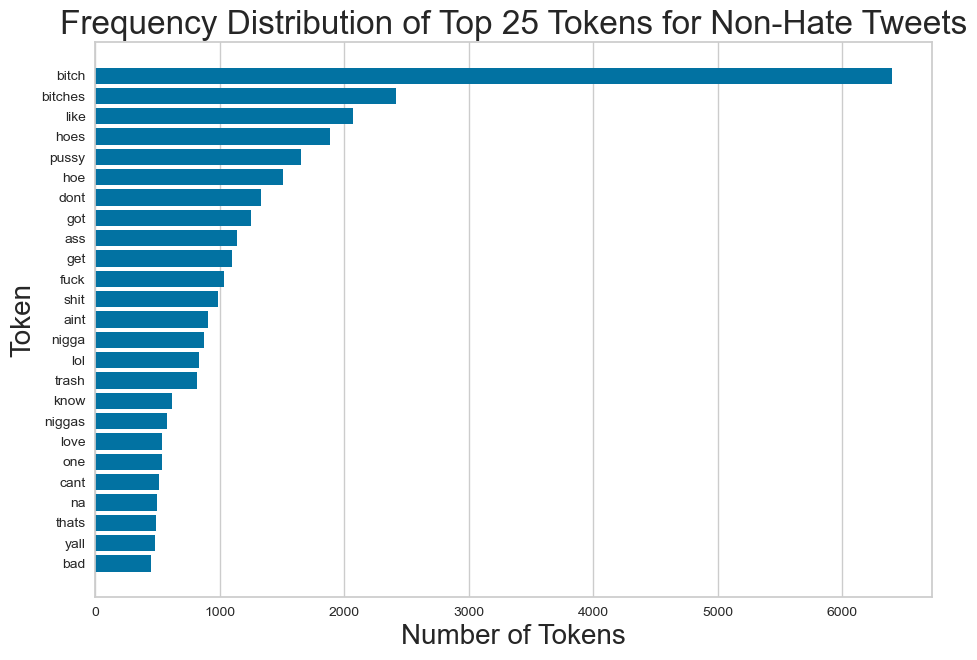

In [39]:
vec = CountVectorizer()
docs = vec.fit_transform(zero_tokenz)
features = vec.get_feature_names_out()
visualizer = FreqDistVisualizer(features=features, orient='h', n=25, size=(1080, 720))
visualizer.fit(docs)
custom_viz = visualizer.ax
custom_viz.set_xlabel('Number of Tokens', fontsize=20) 
custom_viz.set_ylabel('Token', fontsize=20)
custom_viz.set_title("Frequency Distribution of Top 25 Tokens for Non-Hate Tweets", fontsize=24)
custom_viz.figure.show()

/var/folders/km/44ysz99x1gn025bdrtlr30f40000gn/T/ipykernel_82211/943172774.py:10: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



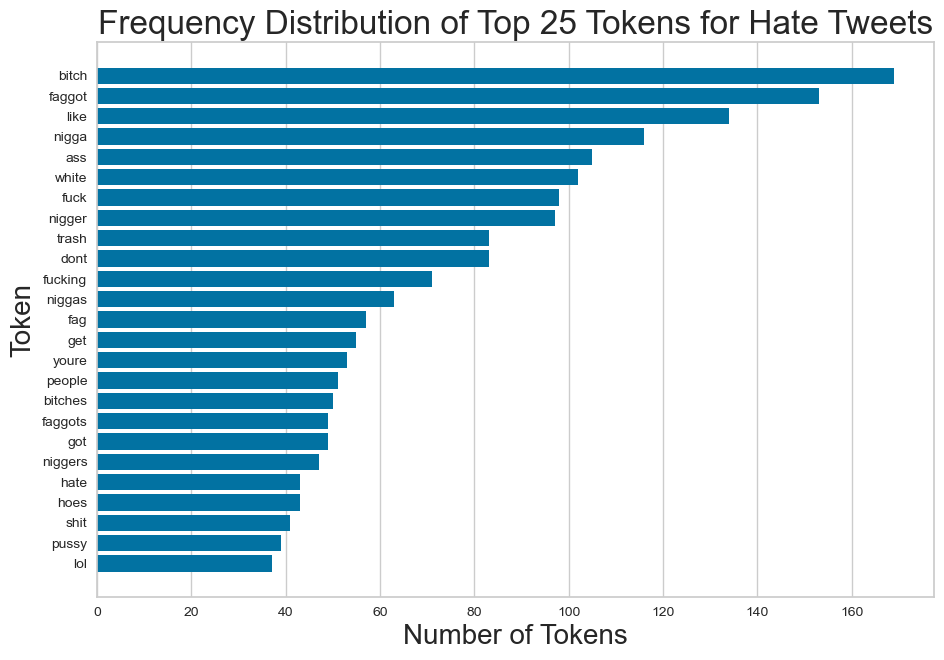

In [40]:
vec = CountVectorizer()
docs = vec.fit_transform(one_tokenz)
features = vec.get_feature_names_out()
visualizer = FreqDistVisualizer(features=features, orient='h', n=25, size=(1080, 720))
visualizer.fit(docs)
custom_viz = visualizer.ax
custom_viz.set_xlabel('Number of Tokens', fontsize=20) 
custom_viz.set_ylabel('Token', fontsize=20)
custom_viz.set_title("Frequency Distribution of Top 25 Tokens for Hate Tweets", fontsize=24)
custom_viz.figure.show()

In [41]:
from wordcloud import WordCloud

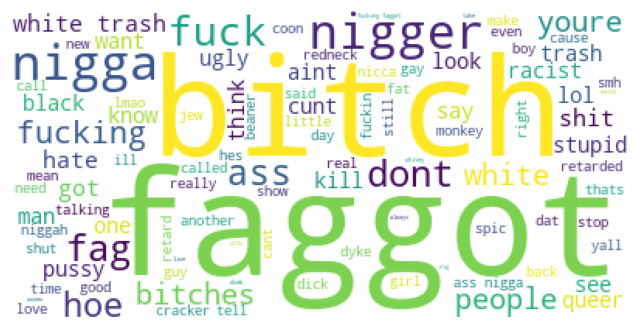

In [42]:
text = ' '.join(one_tokenz)

# # Initialize wordcloud object
wc = WordCloud(background_color='white', max_words=100)

# # Generate and plot wordcloud
plt.imshow(wc.generate(text))
plt.axis('off')
plt.show()

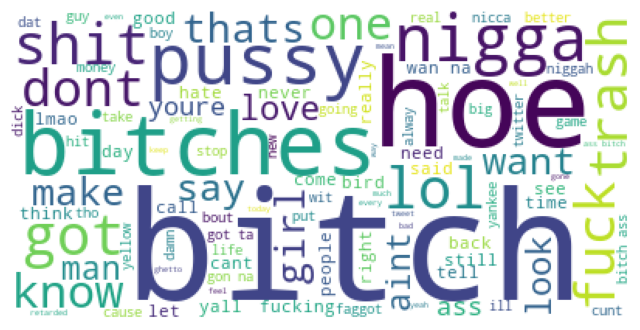

In [43]:
text = ' '.join(zero_tokenz)

# # Initialize wordcloud object
wc = WordCloud(background_color='white', max_words=100)

# # Generate and plot wordcloud
plt.imshow(wc.generate(text))
plt.axis('off')
plt.show()

In [44]:
type(zero_tokenz)

list

In [45]:
hate_list = np.setdiff1d(one_tokenz, zero_tokenz)
hate_list

array(['absolved', 'accord', 'acknowledged', 'activity', 'aflcio', 'aged',
       'agg', 'ahhhahahaha', 'ahmed', 'airlines', 'aklve', 'alaqsa',
       'alcoholics', 'alls', 'alsarabsss', 'amazement', 'americathey',
       'amigo', 'anglo', 'anon', 'antiracist', 'antisemite',
       'antizionist', 'apartheid', 'appearance', 'argentino', 'ariza',
       'arkansas', 'aryan', 'aslina', 'attorney', 'axin', 'azflooding',
       'azmonsoon', 'backpedals', 'baiters', 'baka', 'balless',
       'ballless', 'banner', 'banwagoning', 'barge', 'barnyard',
       'bateman', 'batshit', 'bazinga', 'bdubs', 'beamthat', 'beiber',
       'believes', 'belton', 'benghazzi', 'benton', 'bernstine', 'beta',
       'bias', 'bibles', 'bidens', 'bikes', 'birthdayyyy', 'bisexual',
       'bitcheslook', 'blacklisted', 'blaspheme', 'blondeproblems',
       'boris', 'boyraping', 'brainwash', 'brainwashed', 'bran', 'brits',
       'bromance', 'broner', 'buckcity', 'buffets', 'buku', 'bulldozed',
       'bundle', 'butc

In [46]:
from nltk.stem.porter import PorterStemmer
from textblob import TextBlob
from textblob import Word

In [47]:
def term_frequency(df):
    tf1 = (df['tweet'].apply(lambda x: pd.value_counts(x.split(" "))).sum(axis=0).reset_index())
    tf1.columns = ['words', 'tf']
    tf1 = tf1.sort_values(by='tf', ascending=False).reset_index()
    return tf1

def stemming(token_list):
    ss = PorterStemmer()
    lst = [ss.stem(w) for w in token_list]
    return lst

def lemmatization(df):
    df['lem'] = df['tweet'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))
    return df['lem'].head()

In [48]:
train_stem = stemming(train_tokenz)
val_stem = stemming(val_tokenz)

In [52]:
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/manveerkaur/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/manveerkaur/nltk_data...


True

In [53]:
lemmatization(train)
lemmatization(val)

0                           got missed call from bitch
1    fucking with bad bitch you gone need some mone...
2    lol credit aint where near good but know the r...
3    wipe the cum out them faggot contact lens wild...
4    nigga cheat they bitch and dont expect pay bac...
Name: lem, dtype: object

In [54]:
train.lem = train['lem'].apply(lambda x: ' '.join([item for item in x.split() if item not in stop_list]))
val.lem = val['lem'].apply(lambda x: ' '.join([item for item in x.split() if item not in stop_list]))

In [55]:
train.head()

,tweet,target,lem
0,well how else will white ppl get forget our ...,1,well else white ppl get forget horrific past p...
1,funny thing isits not just the people doing i...,0,funny thing isits people people seeing pic jud...
2,nigga messed with the wrong bitch,0,nigga messed wrong bitch
3,bitch ass nigggaaa,0,bitch nigggaaa
4,that real bitch,0,real bitch


In [56]:
X_tr = train.lem
X_val = val.lem
y_tr = train.target
y_val = val.target

In [57]:
vec = TfidfVectorizer()
tfidf_tr = vec.fit_transform(X_tr)
tfidf_val = vec.transform(X_val)

In [60]:
from sklearn.naive_bayes import MultinomialNB

In [63]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, classification_report,balanced_accuracy_score, precision_recall_curve

In [68]:
def get_metrics(X_tr, y_tr, X_val, y_val, y_pred_tr, y_pred_val, model):
    """
        Function to get training and validation F1, recall, precision, PR AUC scores
        Instantiate model and pass the model into function
        Pass X_train, y_train, X_val, Y_val datasets
        Pass in calculated model.predict(X) for y_pred
    """    
    f1_tr = f1_score(y_tr, y_pred_tr)
    f1_val = f1_score(y_val, y_pred_val)
    rc_tr = recall_score(y_tr, y_pred_tr)
    rc_val = recall_score(y_val, y_pred_val)
    pr_tr = precision_score(y_tr, y_pred_tr)
    pr_val = precision_score(y_val, y_pred_val)
    #aps_tr = aps(X_tr, y_tr, model)
    #aps_val = aps(X_val, y_val, model)
    
    print('Training F1 Score: ', f1_tr)
    print('Validation F1 Score: ', f1_val)
    print('Training Recall Score: ', rc_tr)
    print('Validation Recall Score: ', rc_val)
    print('Training Precision Score: ', pr_tr)
    print('Validation Precision Score: ', pr_val)
    #print('Training Average Precision Score: ', aps_tr)
    #print('Validation Average Precision Score: ', aps_val)


In [69]:
nb = MultinomialNB().fit(tfidf_tr, y_tr)
y_pr_nb_tr = nb.predict(tfidf_tr)
y_pr_nb_val = nb.predict(tfidf_val)
get_metrics(tfidf_tr, y_tr, tfidf_val, y_val, y_pr_nb_tr, y_pr_nb_val, nb)

make_confusion_matrix(cf = confusion_matrix(y_tr, y_pr_nb_tr),
                      X = tfidf_val,
                      y = y_val,
                      model = nb,
                      cmap='Purples',
                      title='Confusion Matrix for Naive Bayes')

Training F1 Score:  0.012195121951219513
Validation F1 Score:  0.0
Training Recall Score:  0.0061403508771929825
Validation Recall Score:  0.0
Training Precision Score:  0.875
Validation Precision Score:  0.0


/Users/manveerkaur/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



NameError: name 'make_confusion_matrix' is not defined